# BC3: Market Basket Analysis for Instacart

Market Basket
The market basket is a list of some fixed items that are used to track the inflation and overall price movements of a specific market in an economy. In other words, it is a basket that contains a set of standard goods or services that people commonly buys.

Market Basket Analysis
Market basket analysis is a method or technique of data analysis for retail and marketing purpose. Market basket analysis is done to understand the purchasing behavior of customers. MBA (Market Business Analysis) is used to uncover what items are frequently brought together by the customer. Market basket analysis leads to effective sales and marketing.Market basket analysis measures the co-occurrence of products and services. Market basket analysis is only considered when there is a transaction between two or more items.

Eg:if a customer is buying bread then he is likely to buy butter, jam or milk to compliment bread.

Applications of Market Basket Analysis
Market basket analysis is applied to various fields of the retail sector in order to boost sales and generate revenue by identifying the needs of the customers and make purchase suggestions to them.

Cross-selling is basically a sales technique in which seller suggests some related product to a customer after he buys a product.
Product Placement: It refers to placing the complimentary (pen and paper)and substitute goods (tea and coffee) together so that the customer addresses the goods and will buy both the goods together.
MBA has also been used in the field of healthcare for the detection of adverse drug reactions. It produces association rules that indicates what all combinations of medications and patient characteristics lead to ADRs.
Fraud Detection: Market basket analysis is also applied to fraud detection. It may be possible to identify purchase behavior that can associate with fraud on the basis of market basket analysis data that contain credit card usage
How Market Based Analysis Works
In order to make it easier to understand, think of Market Basket Analysis in terms of shopping at a supermarket. Market Basket Analysis takes data at transaction level, which lists all items bought by a customer in a single purchase. The technique determines relationships of what products were purchased with which other product(s). These relationships are then used to build profiles containing If-Then rules of the items purchased.

The rules are written as :

if {A} then {B} i.e. {A} => {B}

The If part of the rule (the {A} above) is known as the antecedent and the THEN part of the rule is known as the consequent (the {B} above). The antecedent is the condition and the consequent is the result.

Assosciation Rules
Association Rules are widely used to analyze retail basket or transaction data, and are intended to identify strong rules discovered in transaction data using measures of interestingness, based on the concept of strong rules.

Let I={i1,i2,i3,…,in} be a set of n attributes called items and D={t1,t2,…,tn} be the set of transactions. It is called database. Every transaction, ti in D has a unique transaction ID, and it consists of a subset of itemsets in I.

In [413]:
## Import packages
# Library treatments
import pandas as pd
import numpy as np
import datetime as dt
# 
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

import matplotlib.pyplot as plt
import networkx as nx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

from sklearn.cluster import AgglomerativeClustering, KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
import plotly.express as px

import sklearn.preprocessing as prep
import seaborn as sns

In [3]:
# only define IDs for each department
df_departments=pd.read_csv('departments.csv')
df_departments.head()

department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

In [5]:
# 21 departments in the database
df_departments.shape[0]

21

In [4]:
df_order=pd.read_csv('order_products.csv')
df_order.head()

order_id  product_id  add_to_cart_order  reordered
0        10          24                  1          1
1        10          83                  2          1
2        10          16                  3          0
3        10          24                  4          1
4        10          83                  5          1

In [5]:
# 200k single orders
df_order.order_id.unique().shape[0]

200000

In [6]:
# 134 different products were purchased within 200k single orders
df_order.product_id.unique().shape[0]

134

In [7]:
df_user=pd.read_csv('orders.csv')
df_user.head()
#NAN here are because of 1st order

order_id  user_id  order_number  order_dow  order_hour_of_day  \
0   2425083    49125             1          2                 18   
1   1944304   162867             1          3                 17   
2   1201011   147243            14          0                 16   
3   1906860   195275            81          1                 11   
4   2766469    58222             3          6                 11   

   days_since_prior_order  
0                     NaN  
1                     NaN  
2                     3.0  
3                     3.0  
4                     6.0

In [9]:
# Consistent with the first finding
df_user.order_id.unique().shape[0]

200000

In [10]:
# 105273 users account for 200k orders that contain a total of 134 different products
df_user.user_id.unique().shape[0]

105273

In [11]:
# Top 10 most frequent customers
(df_user['user_id'].groupby(df_user['user_id']).count().sort_values(ascending=False)).head(10)

user_id
8703      15
94289     13
150313    13
62205     13
172966    13
187742    13
58004     13
52167     13
111982    13
11375     13
Name: user_id, dtype: int64

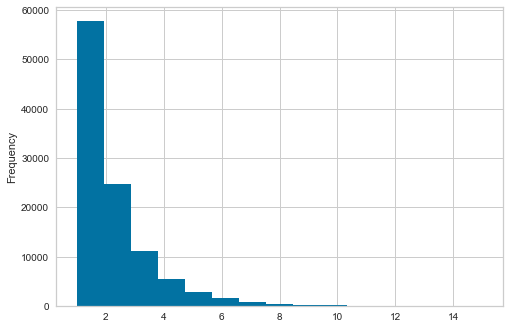

In [12]:
# Most customers did just a few purchases
pd.Series(df_user['user_id'].groupby(df_user['user_id']).count().sort_values(ascending=False).values).plot.hist(bins=15)

In [13]:
df_products=pd.read_csv('products.csv')
df_products.head()

product_id  department_id                product_name
0          61             19               cookies cakes
1         104             13           spices seasonings
2          94              7                         tea
3          38              1                frozen meals
4           5             13  marinades meat preparation

In [14]:
# Consistent with earlier findings: 134 different products
df_products.shape[0]

134

In [15]:
# Consistent with earlier findings: 21 departments
df_products.department_id.unique().shape[0]

21

In [16]:
df = pd.merge(df_order, df_products, how='left', on='product_id')
df = pd.merge(df, df_departments, how='left', on='department_id').\
    drop(["product_id", "department_id"], axis=1)
df.head(16)

order_id  add_to_cart_order  reordered        product_name    department
0         10                  1          1        fresh fruits       produce
1         10                  2          1    fresh vegetables       produce
2         10                  3          0         fresh herbs       produce
3         10                  4          1        fresh fruits       produce
4         10                  5          1    fresh vegetables       produce
5         10                  6          0         fresh herbs       produce
6         10                  7          1        fresh fruits       produce
7         10                  8          1   baby food formula        babies
8         10                  9          1   baby food formula        babies
9         10                 10          0  canned meals beans  canned goods
10        10                 11          0    fresh vegetables       produce
11        10                 12          1               cream    dairy eggs
12        10                 13          0        meat counter  meat seafood
13        10                 14          0    fresh vegetables       produce
14        10                 15          0    fresh vegetables       produce
15        11                  1          1        frozen meals        frozen

In [17]:
# Two million products purchased within 200k orders
df.shape

(2019501, 5)

In [20]:
departments= df.department.unique()
for department in departments:
    print(department ,"\n", df[df['department']==department].product_name.unique())

produce 
 ['fresh fruits' 'fresh vegetables' 'fresh herbs'
 'packaged vegetables fruits' 'packaged produce']
babies 
 ['baby food formula' 'diapers wipes' 'baby bath body care'
 'baby accessories']
canned goods 
 ['canned meals beans' 'canned jarred vegetables' 'soup broth bouillon'
 'canned fruit applesauce' 'canned meat seafood']
dairy eggs 
 ['cream' 'butter' 'other creams cheeses' 'milk' 'packaged cheese' 'yogurt'
 'eggs' 'soy lactosefree' 'refrigerated pudding desserts'
 'specialty cheeses']
meat seafood 
 ['meat counter' 'poultry counter' 'seafood counter'
 'hot dogs bacon sausage' 'packaged poultry' 'packaged seafood'
 'packaged meat']
frozen 
 ['frozen meals' 'frozen produce' 'frozen juice' 'frozen breakfast'
 'ice cream ice' 'frozen vegan vegetarian' 'frozen appetizers sides'
 'frozen breads doughs' 'frozen meat seafood' 'frozen pizza'
 'frozen dessert']
deli 
 ['fresh dips tapenades' 'prepared soups salads' 'tofu meat alternatives'
 'lunch meat' 'prepared meals']
snacks 
 ['c

In [21]:
df[df['department']=='missing']

order_id  add_to_cart_order  reordered product_name department
820          1676                  7          1      missing    missing
1246         2362                  8          0      missing    missing
1907         3958                  3          1      missing    missing
2020         4231                 10          0      missing    missing
2427         4927                  5          1      missing    missing
...           ...                ...        ...          ...        ...
2018940   3399680                 16          1      missing    missing
2019020   3400827                 12          0      missing    missing
2019037   3400846                 10          0      missing    missing
2019093   3404027                  1          1      missing    missing
2019325   3413986                  6          0      missing    missing

[4749 rows x 5 columns]

In [22]:
# Same rows that contain missing product, is a missing department 
df[df['product_name']=='missing'].shape

(4749, 5)

In [23]:
# since these are just 0.2% of our dataset and are we can produce an analysis for product and category we will erase it from the dataset
len(df[df['department']=='missing'])/len(df)

0.002351571006897248

In [24]:
df = df[df['department']!='missing']

In [26]:
df_user.head()

order_id  user_id  order_number  order_dow  order_hour_of_day  \
0   2425083    49125             1          2                 18   
1   1944304   162867             1          3                 17   
2   1201011   147243            14          0                 16   
3   1906860   195275            81          1                 11   
4   2766469    58222             3          6                 11   

   days_since_prior_order  
0                     NaN  
1                     NaN  
2                     3.0  
3                     3.0  
4                     6.0

In [27]:
# percentage of first orders
df_user.isna().sum()[5]/df_user.order_id.unique().shape[0]

0.06127

In [28]:
df = pd.merge(df, df_user, how='left', on='order_id')
df.isna().sum()

order_id                       0
add_to_cart_order              0
reordered                      0
product_name                   0
department                     0
user_id                        0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    124201
dtype: int64

In [29]:
# Not ideal but NAs must be dealt with
df.fillna(0, inplace = True)

In [30]:
df.isna().sum()

order_id                  0
add_to_cart_order         0
reordered                 0
product_name              0
department                0
user_id                   0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

In [31]:
round(df.describe(),2)

order_id  add_to_cart_order   reordered     user_id  order_number  \
count  2014752.00         2014752.00  2014752.00  2014752.00    2014752.00   
mean   1707024.42               8.36        0.59   103068.57         17.14   
std     985956.69               7.15        0.49    59491.69         17.52   
min         10.00               1.00        0.00        2.00          1.00   
25%     852666.00               3.00        0.00    51584.00          5.00   
50%    1704989.00               6.00        1.00   102690.00         11.00   
75%    2559104.00              11.00        1.00   154600.00         24.00   
max    3421080.00             137.00        1.00   206209.00        100.00   

        order_dow  order_hour_of_day  days_since_prior_order  
count  2014752.00         2014752.00              2014752.00  
mean         2.74              13.44                   10.69  
std          2.09               4.24                    9.11  
min          0.00               0.00                    0.00  
25%          1.00              10.00                    4.00  
50%          3.00              13.00                    7.00  
75%          5.00              16.00                   15.00  
max          6.00              23.00                   30.00

In [32]:
(df_user['order_dow'].groupby(df_user['order_dow']).count().sort_values(ascending=False)).sort_values(ascending=False)

order_dow
0    35078
1    34348
2    27277
5    26557
6    26096
3    25670
4    24974
Name: order_dow, dtype: int64

In [33]:
(df_user['order_hour_of_day'].groupby(df_user['order_hour_of_day']).count().sort_values(ascending=False)).sort_values(ascending=False).head()

order_hour_of_day
10    17102
11    16748
15    16649
14    16600
13    16189
Name: order_hour_of_day, dtype: int64

In [34]:
(df['department'].groupby(df['department']).count().sort_values(ascending=False)).sort_values(ascending=False).head()

department
produce       588996
dairy eggs    336915
snacks        180692
beverages     168126
frozen        139536
Name: department, dtype: int64

In [35]:
prods = pd.read_csv('products.csv')

In [36]:
# Import order product dataset
df_p = pd.read_csv('order_products.csv', usecols=['order_id', 'product_id'])

In [37]:
# Merge product labels
df_prod = pd.merge(df_p, prods, how='left', on='product_id').\
    drop(["product_id", "department_id"], axis=1)
df_prod.head()

order_id      product_name
0        10      fresh fruits
1        10  fresh vegetables
2        10       fresh herbs
3        10      fresh fruits
4        10  fresh vegetables

In [38]:
# Pivot the data - lines as orders and products as columns
pt_prods = pd.pivot_table(df_prod, index='order_id', columns='product_name',\
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
pt_prods.head()

product_name  air fresheners candles  asian foods  baby accessories  \
order_id                                                              
10                               0.0          0.0               0.0   
11                               0.0          0.0               0.0   
28                               0.0          0.0               0.0   
38                               0.0          0.0               0.0   
56                               0.0          0.0               0.0   

product_name  baby bath body care  baby food formula  bakery desserts  \
order_id                                                                
10                            0.0                1.0              0.0   
11                            0.0                0.0              0.0   
28                            0.0                0.0              0.0   
38                            0.0                0.0              0.0   
56                            0.0                0.0              0.0   

product_name  baking ingredients  baking supplies decor  beauty  \
order_id                                                          
10                           0.0                    0.0     0.0   
11                           0.0                    0.0     0.0   
28                           0.0                    0.0     0.0   
38                           0.0                    0.0     0.0   
56                           0.0                    0.0     0.0   

product_name  beers coolers  ...  spreads  tea  tofu meat alternatives  \
order_id                     ...                                         
10                      0.0  ...      0.0  0.0                     0.0   
11                      0.0  ...      0.0  0.0                     0.0   
28                      0.0  ...      1.0  0.0                     0.0   
38                      0.0  ...      0.0  0.0                     0.0   
56                      0.0  ...      0.0  0.0                     0.0   

product_name  tortillas flat bread  trail mix snack mix  trash bags liners  \
order_id                                                                     
10                             0.0                  0.0                0.0   
11                             0.0                  0.0                0.0   
28                             0.0                  0.0                0.0   
38                             0.0                  0.0                0.0   
56                             0.0                  0.0                0.0   

product_name  vitamins supplements  water seltzer sparkling water  \
order_id                                                            
10                             0.0                            0.0   
11                             0.0                            0.0   
28                             0.0                            0.0   
38                             0.0                            0.0   
56                             0.0                            0.0   

product_name  white wines  yogurt  
order_id                           
10                    0.0     0.0  
11                    0.0     0.0  
28                    0.0     1.0  
38                    0.0     0.0  
56                    0.0     0.0  

[5 rows x 134 columns]

In [39]:
pt_prods.columns

Index(['air fresheners candles', 'asian foods', 'baby accessories',
       'baby bath body care', 'baby food formula', 'bakery desserts',
       'baking ingredients', 'baking supplies decor', 'beauty',
       'beers coolers',
       ...
       'spreads', 'tea', 'tofu meat alternatives', 'tortillas flat bread',
       'trail mix snack mix', 'trash bags liners', 'vitamins supplements',
       'water seltzer sparkling water', 'white wines', 'yogurt'],
      dtype='object', name='product_name', length=134)

In [40]:
df_d = pd.merge(df_order, df_products, how='left', on='product_id')
df_d = pd.merge(df_d, df_departments, how='left', on='department_id').\
    drop(["product_id", "department_id"], axis=1)
df_d.drop(["add_to_cart_order", "reordered", "product_name", "product_name"], axis=1, inplace=True)

In [41]:
df_d.head()

order_id department
0        10    produce
1        10    produce
2        10    produce
3        10    produce
4        10    produce

In [42]:
# Pivot the data - lines as orders and categories as columns
pt_departs = pd.pivot_table(df_d, index='order_id', columns='department',\
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
pt_departs.head()

department  alcohol  babies  bakery  beverages  breakfast  bulk  canned goods  \
order_id                                                                        
10              0.0     1.0     0.0        0.0        0.0   0.0           1.0   
11              0.0     0.0     0.0        0.0        0.0   0.0           1.0   
28              0.0     0.0     0.0        0.0        0.0   0.0           0.0   
38              0.0     0.0     0.0        0.0        0.0   0.0           0.0   
56              0.0     0.0     0.0        1.0        0.0   0.0           1.0   

department  dairy eggs  deli  dry goods pasta  ...  household  international  \
order_id                                       ...                             
10                 1.0   0.0              0.0  ...        0.0            0.0   
11                 0.0   1.0              0.0  ...        0.0            0.0   
28                 1.0   0.0              0.0  ...        0.0            0.0   
38                 0.0   0.0              0.0  ...        0.0            0.0   
56                 1.0   0.0              0.0  ...        0.0            0.0   

department  meat seafood  missing  other  pantry  personal care  pets  \
order_id                                                                
10                   1.0      0.0    0.0     0.0            0.0   0.0   
11                   0.0      0.0    0.0     1.0            0.0   0.0   
28                   1.0      0.0    0.0     1.0            0.0   0.0   
38                   0.0      0.0    0.0     1.0            0.0   0.0   
56                   0.0      0.0    0.0     1.0            0.0   0.0   

department  produce  snacks  
order_id                     
10              1.0     0.0  
11              0.0     1.0  
28              1.0     0.0  
38              1.0     1.0  
56              1.0     0.0  

[5 rows x 21 columns]

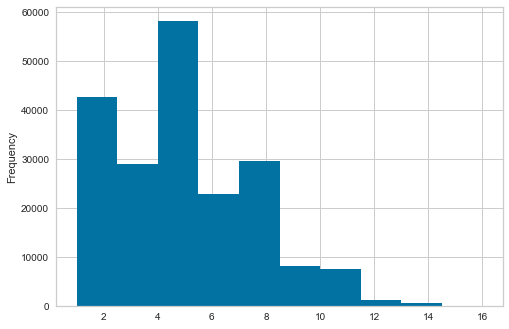

In [43]:
# Most purchases more than one department
pt_departs.sum(axis=1).plot.hist()

# Association Rules through different algorithms

## Apriori Algorithm

Apriori algorithm is a classical algorithm in data mining. It is used for mining frequent itemsets and relevant association rules. It is devised to operate on a database containing a lot of transactions, for instance, items brought by customers in a store.Association rule learning is a prominent and a well-explored method for determining relations among variables in large databases.

Rule - generation is a two step process. First is to generate frequent item set and second is to generate rules from the considered itemset.

1.Generating Frequent Itemset:
One approach to find the frequent itemsets is to check all possible subsets of the given item set and check the support value of each itemset and consider only those that have support values greater than the minimum threshold support value.

Here the Apriori uses the result of antimontone property of support and makes the generation of frequent Item set faster by reducing the search space.It has two principles:

All subsets of a frequent itemset must be frequent
Similarly, for any infrequent itemset, all its supersets must be infrequent too
Apriori principle allows us to prune all supersets of an itemset which does nogt satisfy the minimum threshold condition for support.For example if {Milk,Bread} does not satify our threshold value , then the superset of {Milk,Bread} will also not cross the threshold value there by we can just prune them away i.e. do not consider the itemsets that wil be generated from the {Milk,Bread}.

Totally 3 major steps are involved here:

Generate all frequent itemsets each satisfying the minimum threshold and having only one item let it be L1. Next use self join and generate all possible combinations of L1 and now let the result be L2.
At each step as we keep on generating candidate itemsets, for each candidate we scan entire database so as to know its support and remove the candidates that do not satisfy minimum threshold
Here To reduce the no of comparisions, store the generated candidate items in a Hash Tree,Instead of matching each of candidate itemsets against each transaction,match each transaction with the candidates in hash tree(there by we can enhance the speed of apriori using this method)
In similar way create Lk from Lk-1 until the point where we are unable to apply selfjoin.
This approach of extending a frequent itemset one at a time is called the “bottom up” approach.



2.Generating all possible rules from Frequent Itemsets
If n items are in set I , no of possible assosciation rules possible are 3<supn</sup>- 2n+1 + 1.It becomes computationally expensive to generate all the rules and there is no meaning in genearting all that many no. of rules.

So apriori simplifies this approach by following some methodology,

Rules are formed by binary partition of each itemset.From a list of all possible candidate rules, we aim to identify rules that fall above the minimum confidence level.Just like antimontone property of support, confidence of rules generated from same itemset also follow the anti montone property. It's antimontone w.r.t no. of elements in consequent.

=> CONF(A,B,C -> D) >= CONF(B,C -> A,D) >= CONF(C -> A,B,D)

On the basis of this rules are generated.

If you want to refer further on Advanced Apriori Algorithms, Please refer to Advanced Apriori Algorithms.

Apriori uses a breadth-first search strategy to count the support of itemsets and uses a candidate generation function which exploits the downward closure property of support.

Pros of the Apriori algorithm:

It is an easy-to-implement and easy-to-understand algorithm.
It can be used on large itemsets.
Cons of the Apriori Algorithm:
Sometimes, it may need to find a large number of candidate rules which can be computationally expensive.
Calculating support is also expensive because it has to go through the entire database.

#### About the measures we are going to use for selecting complementary and substitute products through association rules
There are various metrics in place to help us understand the strength of assosciation between antecedent and consequent:

Support
Confidence
Lift or Correlation or interest
Leverage
Conviction
Support
It gives an idea of how frequent an itemset is in all the transactions.To say in formal terms it's the fraction of total no. of transactions in which the itemset occurs.We refer to an itemset as a "frequent itemset" if you support is larger than a specified minimum-support threshold.

supp(X−>Y)=(TransactionscontainingbothXandY)(TotalNo.oftransactions)
 
Range:[0,1] Value of support helps us identifying the rules worth for future analysis.

Confidence
It defines the likelihood of occurence of consequent on the cart given that cart already has antecedent.It signifies the likelihood of item Y being purchased when item X is purchased.

confidence(X−>Y)=support(X−>Y)support(X)
 
Range:[0,1]

If confidence is 0.75 then that imples that 75%of transactions containing X also contain Y .It can also be interpreted as the conditional probability P(Y|X), i.e, the probability of finding the itemset Y in transactions given the transaction already contains X.

It has a major drawback i.e. It only takes into account the popularity of the itemset X and not the popularity of Y. If Y is equally popular as X then there will be a higher probability that a transaction containing X will also contain Y thus increasing the confidence. To overcome this drawback there is another measure called lift.

Lift
Lift gives the rise in the probability of having {Y} on the cart with the knowlede of {X} being present over the probability of having {Y} on the cart without knowlede about presence of {X}.

Lift(X−>Y)=confidence(X−>Y)support(Y)
 
Range:[0,Infinity]

It can simply be considered as correlation between the antecedent and consequent.If the value of lift is greater than 1, it means that the itemset Y is likely to be bought with itemset X, while a value less than 1 implies that itemset Y is unlikely to be bought if the itemset X is bought.

Levarage or Piatetsky-Snapiro
It computes the difference between the observed frequency of X & Y appearing together and the frequency that we would expect if A and C are independent.

Leverage(X−>Y)=support(X−>Y)−support(X)∗support(Y)
 
Range:[-1,1]

If X,Y are positively correlated then we get leverage>0 ,we need such type of rules.
If X,Y are negatively correlated then we get leverage<0.
If X,y are independent , then we get leverage = 0.

Conviction
It can be interpreted as the ratio of the expected frequency that X occurs without Y (that is to say, the frequency that the rule makes an incorrect prediction) if X and Y were independent divided by the observed frequency of incorrect predictions.

Conviction(X−>Y)=support(Y)confidence(X−>Y)
 
Please mark in the above equation Y means it is Y bar i.e. a bar on Y

Range:[0,Infinity]

A high conviction value means that the consequent is highly depending on the antecedent. For instance, in the case of a perfect confidence score, the denominator becomes 0 (due to 1 - 1) for which the conviction score is defined as 'inf'. Similar to lift, if items are independent, the conviction is 1.

In [482]:
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 5% of the transactions (more info at http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/)
frequent_itemsets_2 = apriori(pt_prods, min_support=0.02, use_colnames=True)
frequent_itemsets_2.head()

support              itemsets
0  0.043330         (asian foods)
1  0.045355   (baby food formula)
2  0.076635  (baking ingredients)
3  0.163865               (bread)
4  0.067765    (breakfast bakery)

In [419]:
# Complementary products
rulesComplementary = association_rules(frequent_itemsets_2, metric="confidence", min_threshold=0.7)
rulesComplementary.sort_values(by='lift', ascending=True, inplace=True)
rulesComplementary = rulesComplementary[(rulesComplementary.lift > 1.5)
                                                 & (rulesComplementary.conviction > 1.5)]
rulesComplementary["ant_lenght"] = rulesComplementary.antecedents.apply(lambda x: len(x))
rulesComplementary["con_lenght"] = rulesComplementary.consequents.apply(lambda x: len(x))
print(rulesComplementary.shape[0])
rulesComplementary.head()

185


antecedents     consequents  \
104  (packaged vegetables fruits, energy granola bars)  (fresh fruits)   
268                     (eggs, fresh vegetables, milk)  (fresh fruits)   
261  (crackers, packaged vegetables fruits, package...  (fresh fruits)   
347  (packaged vegetables fruits, packaged cheese, ...  (fresh fruits)   
235                   (bread, packaged cheese, yogurt)  (fresh fruits)   

     antecedent support  consequent support   support  confidence      lift  \
104            0.039500            0.555995  0.032945    0.834051  1.500105   
268            0.030660            0.555995  0.025580    0.834312  1.500574   
261            0.024475            0.555995  0.020420    0.834321  1.500590   
347            0.025970            0.555995  0.021675    0.834617  1.501123   
235            0.027480            0.555995  0.022945    0.834971  1.501760   

     leverage  conviction  ant_lenght  con_lenght  
104  0.010983    2.675545           2           1  
268  0.008533    2.679762           3           1  
261  0.006812    2.679907           3           1  
347  0.007236    2.684705           3           1  
235  0.007666    2.690465           3           1

In [420]:
rulesComplementary.consequents.value_counts()

(fresh vegetables)                  107
(fresh fruits)                       74
(fresh fruits, fresh vegetables)      3
(packaged vegetables fruits)          1
Name: consequents, dtype: int64

In [300]:
# Substitue products
rulesSubstitute = association_rules(frequent_itemsets_2, metric="lift", min_threshold=0.0)
rulesSubstitute.sort_values(by='lift', ascending=True, inplace=True)
rulesSubstitute = rulesSubstitute[(rulesSubstitute.lift < 1.0)
                                                 & (rulesSubstitute.conviction < 0.99)]
rulesSubstitute["ant_lenght"] = rulesSubstitute.antecedents.apply(lambda x: len(x))
rulesSubstitute["con_lenght"] = rulesSubstitute.consequents.apply(lambda x: len(x))
rulesSubstitute.head()

antecedents                   consequents  \
460            (fresh vegetables)                 (soft drinks)   
461                 (soft drinks)            (fresh vegetables)   
643                 (soft drinks)  (packaged vegetables fruits)   
642  (packaged vegetables fruits)                 (soft drinks)   
376                (fresh fruits)                 (soft drinks)   

     antecedent support  consequent support   support  confidence      lift  \
460            0.444360            0.087310  0.027845    0.062663  0.717709   
461            0.087310            0.444360  0.027845    0.318921  0.717709   
643            0.087310            0.365415  0.024480    0.280380  0.767293   
642            0.365415            0.087310  0.024480    0.066992  0.767293   
376            0.555995            0.087310  0.039585    0.071197  0.815447   

     leverage  conviction  
460 -0.010952    0.973705  
461 -0.010952    0.815823  
643 -0.007424    0.881834  
642 -0.007424    0.978223  
376 -0.008959    0.982652

In [301]:
rulesSubstitute.shape[0]

18

In [154]:
frequent_departsets_2 = apriori(pt_departs, min_support=0.02, use_colnames=True)
frequent_departsets_2.head()

support     itemsets
0  0.026005    (alcohol)
1  0.054550     (babies)
2  0.273565     (bakery)
3  0.456190  (beverages)
4  0.163495  (breakfast)

In [282]:
# Substitue departments
rulesSubstitute_departs = association_rules(frequent_departsets_2, metric="lift", min_threshold=0.0)
rulesSubstitute_departs.sort_values(by='lift', ascending=True, inplace=True)
rulesSubstitute_departs = rulesSubstitute_departs[(rulesSubstitute_departs.lift < 1.0)
                                                 & (rulesSubstitute_departs.conviction < 0.95)]
rulesSubstitute_departs["ant_lenght"] = rulesSubstitute_departs.antecedents.apply(lambda x: len(x))
rulesSubstitute_departs["con_lenght"] = rulesSubstitute_departs.consequents.apply(lambda x: len(x))
rulesSubstitute_departs

antecedents consequents  antecedent support  \
2016  (personal care, household)   (produce)            0.033120   
187                  (household)   (produce)            0.147675   
209              (personal care)   (produce)            0.099480   
953       (household, beverages)   (produce)            0.085035   
65                   (beverages)   (produce)            0.456190   
1014  (personal care, beverages)   (produce)            0.056865   

      consequent support   support  confidence      lift  leverage  conviction  
2016            0.748065  0.022325    0.674064  0.901077 -0.002451    0.772959  
187             0.748065  0.102695    0.695412  0.929615 -0.007775    0.827134  
209             0.748065  0.070550    0.709188  0.948030 -0.003868    0.866315  
953             0.748065  0.061145    0.719057  0.961222 -0.002467    0.896747  
65              0.748065  0.334630    0.733532  0.980573 -0.006630    0.945461  
1014            0.748065  0.041760    0.734371  0.981694 -0.000779    0.948446

In [208]:
# Substitue products
rulesComplementary_departs = association_rules(frequent_departsets_2, metric="confidence", min_threshold=0.5)
rulesComplementary_departs.sort_values(by='lift', ascending=True, inplace=True)
rulesComplementary_departs_ = rulesComplementary_departs[(rulesComplementary_departs.lift > 1.5) 
                                                             & (rulesComplementary_departs.confidence >= 0.7) 
                                                             & (rulesComplementary_departs.conviction >= 2)].sort_values(by='lift', ascending=False)
rulesComplementary_departs_["ant_lenght"] = rulesComplementary_departs_.antecedents.apply(lambda x: len(x))
rulesComplementary_departs_["con_lenght"] = rulesComplementary_departs_.consequents.apply(lambda x: len(x))
rulesComplementary_departs_

antecedents            consequents  \
4149         (deli, produce, breakfast, beverages)   (dairy eggs, snacks)   
2560                  (deli, breakfast, beverages)   (dairy eggs, snacks)   
4694    (deli, beverages, produce, frozen, bakery)   (dairy eggs, snacks)   
3941          (produce, breakfast, bakery, pantry)   (dairy eggs, snacks)   
3928          (produce, breakfast, bakery, frozen)   (dairy eggs, snacks)   
...                                            ...                    ...   
4400  (snacks, frozen, beverages, dry goods pasta)  (dairy eggs, produce)   
3521             (pantry, frozen, dry goods pasta)  (dairy eggs, produce)   
3326                (canned goods, frozen, pantry)  (dairy eggs, produce)   
3465                        (deli, frozen, pantry)  (dairy eggs, produce)   
3884           (snacks, beverages, pantry, bakery)  (dairy eggs, produce)   

      antecedent support  consequent support   support  confidence      lift  \
4149            0.027930            0.322820  0.020010    0.716434  2.219299   
2560            0.031040            0.322820  0.021925    0.706347  2.188051   
4694            0.029850            0.322820  0.020970    0.702513  2.176174   
3941            0.031435            0.322820  0.022070    0.702084  2.174846   
3928            0.033345            0.322820  0.023355    0.700405  2.169645   
...                  ...                 ...       ...         ...       ...   
4400            0.038110            0.549105  0.031455    0.825374  1.503126   
3521            0.053990            0.549105  0.044530    0.824782  1.502049   
3326            0.059140            0.549105  0.048770    0.824653  1.501814   
3465            0.057770            0.549105  0.047640    0.824649  1.501807   
3884            0.046525            0.549105  0.038335    0.823966  1.500561   

      leverage  conviction  
4149  0.010994    2.388086  
2560  0.011905    2.306052  
4694  0.011334    2.276331  
3941  0.011922    2.273054  
3928  0.012591    2.260317  
...        ...         ...  
4400  0.010529    2.582060  
3521  0.014884    2.573343  
3326  0.016296    2.571449  
3465  0.015918    2.571392  
3884  0.012788    2.561403  

[224 rows x 9 columns]

In [209]:
rulesComplementary_departs_.shape[0]

224

In [210]:
rulesComplementary_departs_.consequents.value_counts()

(dairy eggs, produce)    140
(snacks)                  76
(dairy eggs, snacks)       5
(frozen)                   2
(produce, snacks)          1
Name: consequents, dtype: int64

## Visualizing Department Rules through scatterplots of different measures
### Complementary rules

##### Scatterplot of deparment complementary rules - Support by Confidence with Color Encoded Lift 

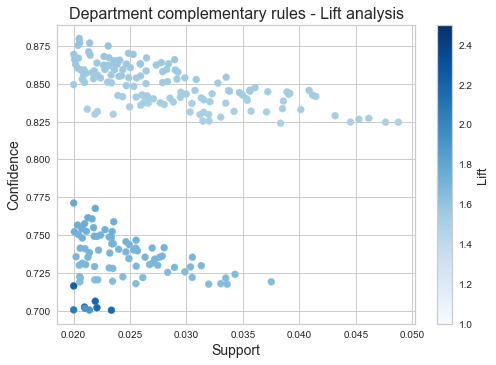

In [244]:
plt.scatter(rulesComplementary_departs_.support, rulesComplementary_departs_.confidence, s=None,
            c=rulesComplementary_departs_.lift, marker=None, cmap='Blues',
            norm=None, vmin=1.0, vmax=2.5, alpha=None,
            linewidths=None, edgecolors=None,
            plotnonfinite=False, data=None)
plt.title('Department complementary rules - Lift analysis', fontsize = 16)
plt.xlabel('Support', fontsize= 14)
plt.ylabel('Confidence', fontsize=14)
cbar = plt.colorbar()
cbar.set_label('Lift', fontsize = 13) #rotation=270)

##### Scatterplot of deparment complementary rules - Support by Confidence with Color Encoded Leverage 

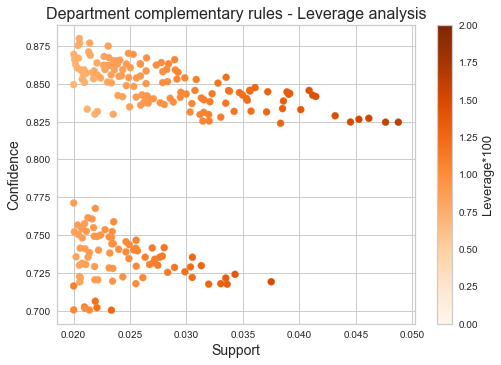

In [334]:
plt.scatter(rulesComplementary_departs_.support, rulesComplementary_departs_.confidence, s=None,
            c=rulesComplementary_departs_.leverage*100, marker=None, cmap='Oranges',
            norm=None, vmin=0, vmax=2, alpha=None,
            linewidths=None, edgecolors=None,
            plotnonfinite=False, data=None)
plt.title('Department complementary rules - Leverage analysis', fontsize = 16)
plt.xlabel('Support', fontsize= 14)
plt.ylabel('Confidence', fontsize=14)
cbar = plt.colorbar()
cbar.set_label('Leverage*100', fontsize = 13) #rotation=270)

##### Scatterplot of deparment complementary rules - Support by Confidence with Color Encoded Conviction 

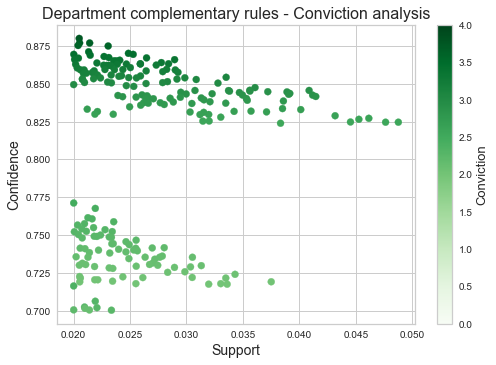

In [246]:
plt.scatter(rulesComplementary_departs_.support, rulesComplementary_departs_.confidence, s=None,
            c=rulesComplementary_departs_.conviction, marker=None, cmap='Greens',
            norm=None, vmin=0, vmax=4, alpha=None,
            linewidths=None, edgecolors=None,
            plotnonfinite=False, data=None)
plt.title('Department complementary rules - Conviction analysis', fontsize = 16)
plt.xlabel('Support', fontsize= 14)
plt.ylabel('Confidence', fontsize=14)
cbar = plt.colorbar()
cbar.set_label('Conviction', fontsize = 13) #rotation=270)

### Substitute Rules
##### Scatterplot of deparment substitute rules - Support by Confidence with Color Encoded Lift  

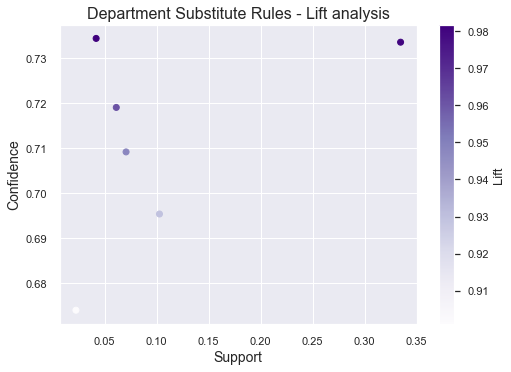

In [474]:
plt.scatter(rulesSubstitute_departs.support, rulesSubstitute_departs.confidence, s=None,
            c=rulesSubstitute_departs.lift, marker=None, cmap='Purples',
            norm=None, vmin=None, vmax=None, alpha=None,
            linewidths=None, edgecolors=None,
            plotnonfinite=False, data=None)
plt.title('Department Substitute Rules - Lift analysis', fontsize = 16)
plt.xlabel('Support', fontsize= 14)
plt.ylabel('Confidence', fontsize=14)
cbar = plt.colorbar()
cbar.set_label('Lift', fontsize = 13) #rotation=270)

##### Scatterplot of deparment substitute rules - Conviction by Lift with Color Encoded Leverage  

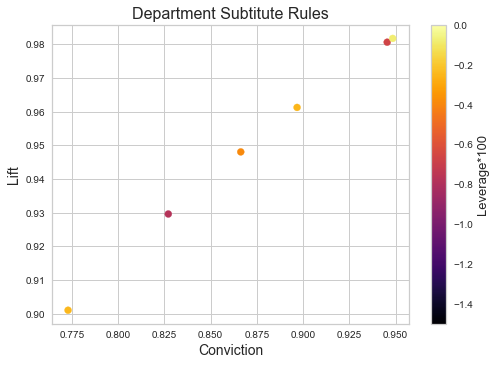

In [359]:
plt.scatter(rulesSubstitute_departs.conviction, rulesSubstitute_departs.lift, s=None,
            c=rulesSubstitute_departs.leverage*100, marker=None, cmap='inferno',
            norm=None, vmin=-0.015*100, vmax=0, alpha=None,
            linewidths=None, edgecolors=None,
            plotnonfinite=False, data=None)
plt.title('Department Subtitute Rules', fontsize = 16)
plt.xlabel('Conviction', fontsize= 14)
plt.ylabel('Lift', fontsize=14)
cbar = plt.colorbar()
cbar.set_label('Leverage*100', fontsize = 13) #rotation=270)

## Visualizing Product Rules through scatterplots of different measures
### Complementary rules
##### Scatterplot of Product complementary rules - Support by Confidence with Color Encoded Lift  

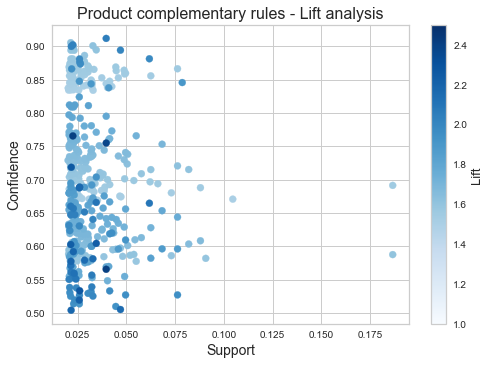

In [350]:
plt.scatter(rulesComplementary.support, rulesComplementary.confidence, s=None,
            c=rulesComplementary.lift, marker=None, cmap='Blues',
            norm=None, vmin=1, vmax=2.5, alpha=None,
            linewidths=None, edgecolors=None,
            plotnonfinite=False, data=None)
plt.title('Product complementary rules - Lift analysis', fontsize = 16)
plt.xlabel('Support', fontsize= 14)
plt.ylabel('Confidence', fontsize=14)
cbar = plt.colorbar()
cbar.set_label('Lift', fontsize = 13) #rotation=270)

##### Scatterplot of Product complementary rules - Support by Confidence with Color Encoded Leverage  

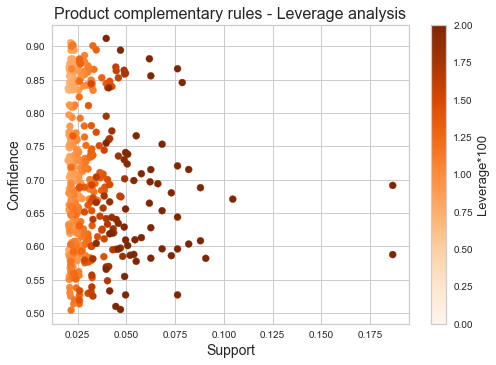

In [356]:
plt.scatter(rulesComplementary.support,rulesComplementary.confidence, s=None,
            c=rulesComplementary.leverage*100, marker=None, cmap='Oranges',
            norm=None, vmin=0, vmax=2, alpha=None,
            linewidths=None, edgecolors=None,
            plotnonfinite=False, data=None)
plt.title('Product complementary rules - Leverage analysis', fontsize = 16)
plt.xlabel('Support', fontsize= 14)
plt.ylabel('Confidence', fontsize=14)
cbar = plt.colorbar()
cbar.set_label('Leverage*100', fontsize = 13) #rotation=270)

##### Scatterplot of Product complementary rules - Support by Confidence with Color Encoded Conviction  

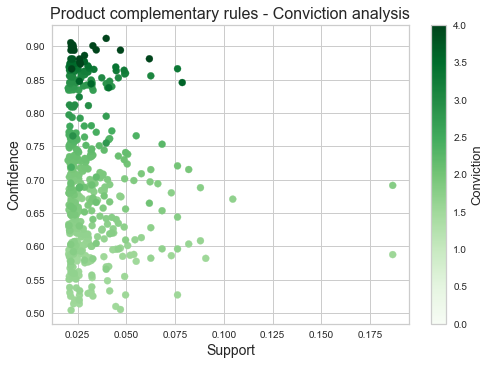

In [357]:
plt.scatter(rulesComplementary.support, rulesComplementary.confidence, s=None,
            c=rulesComplementary.conviction, marker=None, cmap='Greens',
            norm=None, vmin=0, vmax=4, alpha=None,
            linewidths=None, edgecolors=None,
            plotnonfinite=False, data=None)
plt.title('Product complementary rules - Conviction analysis', fontsize = 16)
plt.xlabel('Support', fontsize= 14)
plt.ylabel('Confidence', fontsize=14)
cbar = plt.colorbar()
cbar.set_label('Conviction', fontsize = 13) #rotation=270)

In [ ]:
##### Scatterplot of Product complementary rules - Support by Confidence with Color Encoded Lift  

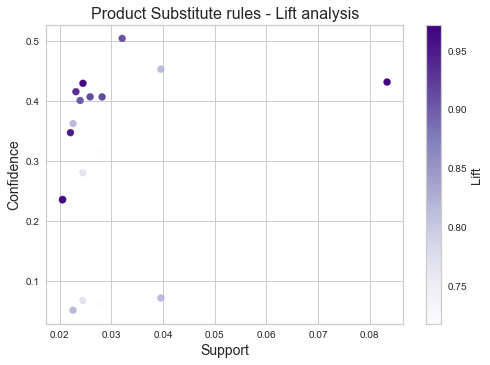

In [361]:
plt.scatter(rulesSubstitute.support, rulesSubstitute.confidence, s=None,
            c=rulesSubstitute.lift, marker=None, cmap='Purples',
            norm=None, vmin=None, vmax=None, alpha=None,
            linewidths=None, edgecolors=None,
            plotnonfinite=False, data=None)
plt.title('Product Substitute rules - Lift analysis', fontsize = 16)
plt.xlabel('Support', fontsize= 14)
plt.ylabel('Confidence', fontsize=14)
cbar = plt.colorbar()
cbar.set_label('Lift', fontsize = 13) #rotation=270)

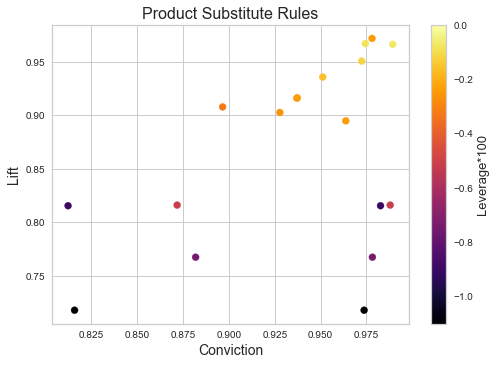

In [363]:
plt.scatter(rulesSubstitute.conviction, rulesSubstitute.lift, s=None,
            c=rulesSubstitute.leverage*100, marker=None, cmap='inferno',
            norm=None, vmin=-0.011*100, vmax=0, alpha=None,
            linewidths=None, edgecolors=None,
            plotnonfinite=False, data=None)
plt.title('Product Substitute Rules', fontsize = 16)
plt.xlabel('Conviction', fontsize= 14)
plt.ylabel('Lift', fontsize=14)
cbar = plt.colorbar()
cbar.set_label('Leverage*100', fontsize = 13) #rotation=270)

### Department top 30 complementary rules

Center of network clusters are consequents and antecedents are the star legs

In [ ]:
### Plot a basic network graph of the top 30 department rules
# Create a copy of the rules and transform the frozensets to strings
rulesToPlot_prods = rulesComplementary_departs.copy(deep=True)
rulesToPlot_prods['LHS'] = [','.join(list(x)) for x in rulesToPlot_prods['antecedents']]
rulesToPlot_prods['RHS'] = [','.join(list(x)) for x in rulesToPlot_prods['consequents']]
# Remove duplicate if reversed rules
rulesToPlot_prods['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot_prods.LHS, rulesToPlot_prods.RHS)]
rulesToPlot_prods['sortedRow'] = rulesToPlot_prods['sortedRow'].astype(str)
rulesToPlot_prods.drop_duplicates(subset=['sortedRow'], inplace=True)
# Plot
rulesToPlot_prods=rulesToPlot_prods[:30]
fig = plt.figure(figsize=(20, 20)) 
G = nx.from_pandas_edgelist(rulesToPlot_prods, 'LHS', 'RHS')  
# Each node is an itemset (either source or target) and the edges connect the itemsets if they consist of a high confidence rule
nx.draw(G, with_labels=True, node_size=30, node_color="lightgrey",
        pos=nx.spring_layout(G), font_size = 18, font_color = 'darkgreen')
plt.axis('equal')
plt.show()
#fig.savefig('figure.svg')
# TRY TO PLOT THE DIRECTION OF SOURCE -> TARGET

### Products top 30 complementary rules
Center of network clusters are consequents and antecedents are the star legs

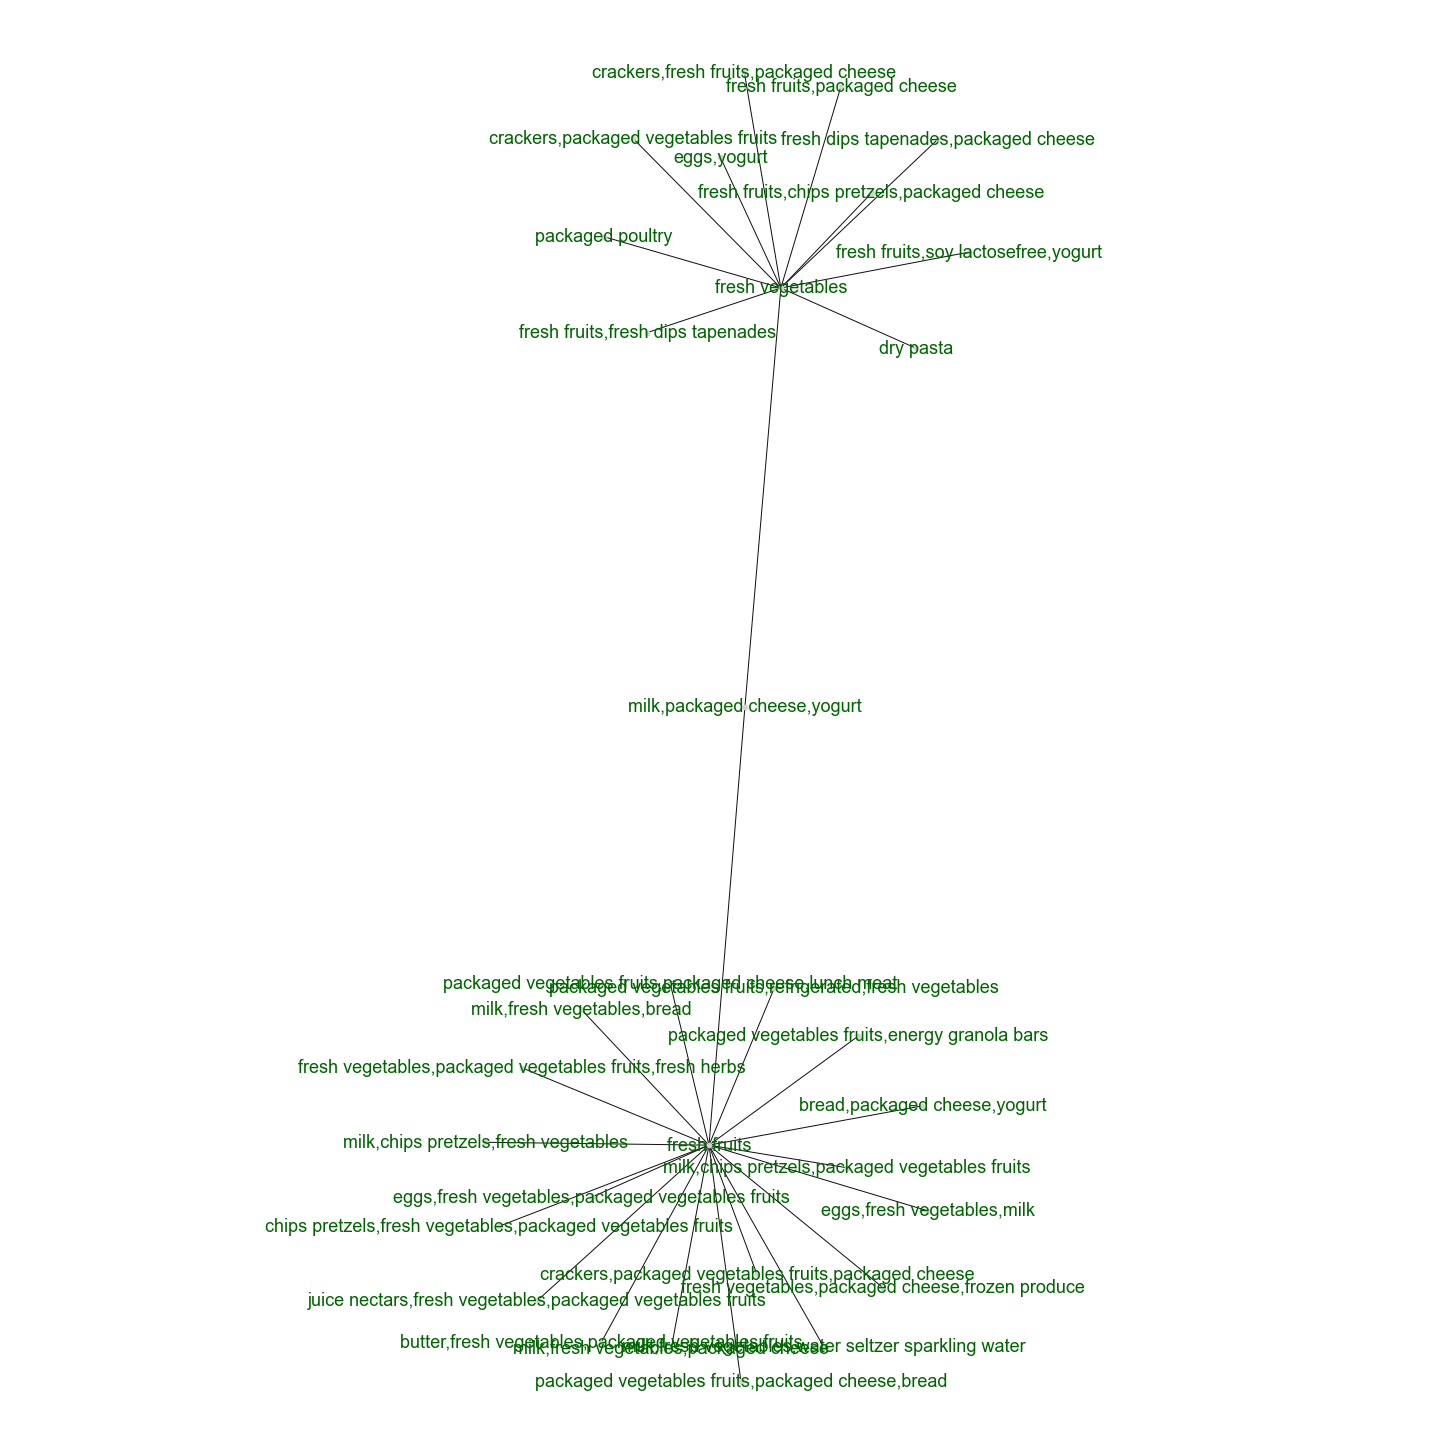

In [385]:
### Plot a basic network graph of the top 30 product rules
# Create a copy of the rules and transform the frozensets to strings
rulesToPlot_prods = rulesComplementary.copy(deep=True)
rulesToPlot_prods['LHS'] = [','.join(list(x)) for x in rulesToPlot_prods['antecedents']]
rulesToPlot_prods['RHS'] = [','.join(list(x)) for x in rulesToPlot_prods['consequents']]
# Remove duplicate if reversed rules
rulesToPlot_prods['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot_prods.LHS, rulesToPlot_prods.RHS)]
rulesToPlot_prods['sortedRow'] = rulesToPlot_prods['sortedRow'].astype(str)
rulesToPlot_prods.drop_duplicates(subset=['sortedRow'], inplace=True)
# Plot
rulesToPlot_prods=rulesToPlot_prods[:30]
fig = plt.figure(figsize=(20, 20)) 
G = nx.from_pandas_edgelist(rulesToPlot_prods, 'LHS', 'RHS')  
# Each node is an itemset (either source or target) and the edges connect the itemsets if they consist of a high confidence rule
nx.draw(G, with_labels=True, node_size=30, node_color="lightgrey", pos=nx.spring_layout(G), font_size = 18, font_color = 'darkgreen')
plt.axis('equal')
plt.show()
#fig.savefig('figure.svg')
# TRY TO PLOT THE DIRECTION OF SOURCE -> TARGET

## FP Algorithm Growth Assessment (Frequent Pattern Growth) 

Shortcomings Of Apriori Algorithm

-Using Apriori needs a generation of candidate itemsets. These itemsets may be large in number if the itemset in the database is huge.

-Apriori needs multiple scans of the database to check the support of each itemset generated and this leads to high costs. These shortcomings can be overcome using the FP growth algorithm.

This algorithm is an improvement to the Apriori method. A frequent pattern is generated without the need for candidate generation. FP growth algorithm represents the database in the form of a tree called a frequent pattern tree or FP tree.

This tree structure will maintain the association between the itemsets. The database is fragmented using one frequent item. This fragmented part is called “pattern fragment”. The itemsets of these fragmented patterns are analyzed. Thus with this method, the search for frequent itemsets is reduced comparatively.

FP TREE

Frequent Pattern Tree is a tree-like structure that is made with the initial itemsets of the database. The purpose of the FP tree is to mine the most frequent pattern. Each node of the FP tree represents an item of the itemset.

The root node represents null while the lower nodes represent the itemsets. The association of the nodes with the lower nodes that is the itemsets with the other itemsets are maintained while forming the tree.

Frequent Pattern Algorithm Steps
The frequent pattern growth method lets us find the frequent pattern without candidate generation.

Let us see the steps followed to mine the frequent pattern using frequent pattern growth algorithm:

1) The first step is to scan the database to find the occurrences of the itemsets in the database. This step is the same as the first step of Apriori. The count of 1-itemsets in the database is called support count or frequency of 1-itemset.

2) The second step is to construct the FP tree. For this, create the root of the tree. The root is represented by null.

3) The next step is to scan the database again and examine the transactions. Examine the first transaction and find out the itemset in it. The itemset with the max count is taken at the top, the next itemset with lower count and so on. It means that the branch of the tree is constructed with transaction itemsets in descending order of count.

4) The next transaction in the database is examined. The itemsets are ordered in descending order of count. If any itemset of this transaction is already present in another branch (for example in the 1st transaction), then this transaction branch would share a common prefix to the root.

This means that the common itemset is linked to the new node of another itemset in this transaction.

5) Also, the count of the itemset is incremented as it occurs in the transactions. Both the common node and new node count is increased by 1 as they are created and linked according to transactions.

6) The next step is to mine the created FP Tree. For this, the lowest node is examined first along with the links of the lowest nodes. The lowest node represents the frequency pattern length 1. From this, traverse the path in the FP Tree. This path or paths are called a conditional pattern base.

Conditional pattern base is a sub-database consisting of prefix paths in the FP tree occurring with the lowest node (suffix).

7) Construct a Conditional FP Tree, which is formed by a count of itemsets in the path. The itemsets meeting the threshold support are considered in the Conditional FP Tree.

8) Frequent Patterns are generated from the Conditional FP Tree.

For example refer to link

##### Assessment on FP Growth Algorithm to see if the algo produces better and different rules: 

In [473]:
fp_itemsets_2=fpgrowth(pt_prods,min_support=0.02,use_colnames=True)

In [421]:
# Substitue products
rulesComplementary_fp_p = association_rules(fp_itemsets_2, metric="confidence", min_threshold=0.7)
rulesComplementary_fp_p.sort_values(by='lift', ascending=True, inplace=True)
rulesComplementary_fp_p = rulesComplementary_fp_p[(rulesComplementary_fp_p.lift > 1.5) 
                                                             & (rulesComplementary_fp_p.conviction >= 1.5)].sort_values(by='lift', ascending=False)
rulesComplementary_fp_p["ant_lenght"] = rulesComplementary_fp_p.antecedents.apply(lambda x: len(x))
rulesComplementary_fp_p["con_lenght"] = rulesComplementary_fp_p.consequents.apply(lambda x: len(x))
rulesComplementary_fp_p.head()

antecedents  \
19                              (fresh herbs, yogurt)   
9           (packaged vegetables fruits, fresh herbs)   
14                     (packaged cheese, fresh herbs)   
7   (fresh fruits, packaged vegetables fruits, fre...   
17                (fresh fruits, fresh herbs, yogurt)   

                         consequents  antecedent support  consequent support  \
19  (fresh fruits, fresh vegetables)            0.029480             0.31756   
9   (fresh fruits, fresh vegetables)            0.052535             0.31756   
14  (fresh fruits, fresh vegetables)            0.030290             0.31756   
7                 (fresh vegetables)            0.043490             0.44436   
17                (fresh vegetables)            0.025015             0.44436   

     support  confidence      lift  leverage  conviction  ant_lenght  \
19  0.022570    0.765604  2.410895  0.013208    2.911481           2   
9   0.039660    0.754925  2.377268  0.022977    2.784620           2   
14  0.021765    0.718554  2.262735  0.012146    2.424763           2   
7   0.039660    0.911934  2.052241  0.020335    6.309343           3   
17  0.022570    0.902259  2.030468  0.011454    5.684799           3   

    con_lenght  
19           2  
9            2  
14           2  
7            1  
17           1

In [422]:
rulesComplementary_fp_p.consequents.value_counts()

(fresh vegetables)                  107
(fresh fruits)                       74
(fresh fruits, fresh vegetables)      3
(packaged vegetables fruits)          1
Name: consequents, dtype: int64

#### FP Growth generated the same results as Aprori algorithm so we will stick to Apriori rules, graphs and findings

#### Clustering analysis 
##### We will use features of orders corresponding to day of purchase, hour of purchases, number of products orderes, % of reordered products and days since prior orders

In [400]:
def kelbowplots(clus_estim, data):
    """
    This function produces the k-elbow plot for a given clustering estimator according to 3 different clustering quality measures: "Distortion", "Silhouette" and "Calinski Harabasz".
    """
    sns.set()
    fig, axes = plt.subplots(1, 3, figsize=(20,7))

    # Plot the data
    metrics = ["distortion", "silhouette", "calinski_harabasz"]
    ylabels = ["Distortion measure", "Silhouette measure", "Calinski Harabasz measure"]
    titles = ["Distortion measure plot", "Silhouette measure plot", "Calinski Harabasz measure plot"]
    for ax, m, yl, tl in zip(axes.flatten(), metrics, ylabels, titles):
        # KElbowVisualizer produces the elbow plot for several quality measures
        KElbowVisualizer(clus_estim, metric=m, timings=False, locate_elbow=True, ax=ax).fit(data)
        ax.invert_xaxis()
        ax.set_ylabel(yl, fontsize=13)
        ax.set_xlabel("Number of clusters", fontsize=13)
        ax.set_title(tl, fontsize=13)

    # Set figure
    plt.suptitle("K-Elbow Plots", fontsize=23)

    plt.show()

In [401]:
def kmeans_clustering(df,nclusters):
    #Scaling
    X = df.to_numpy()
    scaler = prep.MinMaxScaler()
    scaler.fit(X)
    Xs = scaler.transform(X)
    
    # Clustering
    clustering = KMeans(n_clusters=nclusters, n_init=15, random_state=1)
    clustering.fit(Xs)
    cdf = df
    cdf['cluster'] = clustering.labels_
    
    return Xs,cdf

In [402]:
def rsq(df,list_of_columns):

    sst = get_ss(df[list_of_columns])
    ssw_labels = df[list_of_columns + ["cluster"]].groupby(by='cluster').apply(get_ss)
    ssb = sst - np.sum(ssw_labels)
    r2 = ssb / sst

    display('rsq is:', r2)

In [403]:
def get_ss(df):
    
    ss = np.sum(df.var() * (df.count() - 1))
    
    return ss

In [493]:
df_g.head()

order_dow  order_hour_of_day  days_since_prior_order  \
order_id                                                         
10              6.0                8.0                     8.0   
11              1.0               19.0                    23.0   
28              3.0               13.0                     6.0   
38              6.0               16.0                    24.0   
56              0.0               12.0                     2.0   

          number_of_items  %_of_reordered  cluster  
order_id                                            
10                     15        0.533333      2.0  
11                      5        1.000000      1.0  
28                     16        0.875000      2.0  
38                      9        0.111111      2.0  
56                     10        0.700000      3.0

In [394]:
df_g =df.groupby(df['order_id']).mean().iloc[:,-3:]
df_g['number_of_items']= df.groupby(df['order_id']).max().iloc[:,0]

In [396]:
df_g['%_of_reordered']=df.groupby(df['order_id']).mean().iloc[:,1]

In [397]:
df_g.head()

order_dow  order_hour_of_day  days_since_prior_order  \
order_id                                                         
10              6.0                8.0                     8.0   
11              1.0               19.0                    23.0   
28              3.0               13.0                     6.0   
38              6.0               16.0                    24.0   
56              0.0               12.0                     2.0   

          number_of_items  %_of_reordered  
order_id                                   
10                     15        0.533333  
11                      5        1.000000  
28                     16        0.875000  
38                      9        0.111111  
56                     10        0.700000

In [398]:
dfs = pd.DataFrame(prep.MinMaxScaler().fit_transform(df_g), columns=df_g.columns.values)

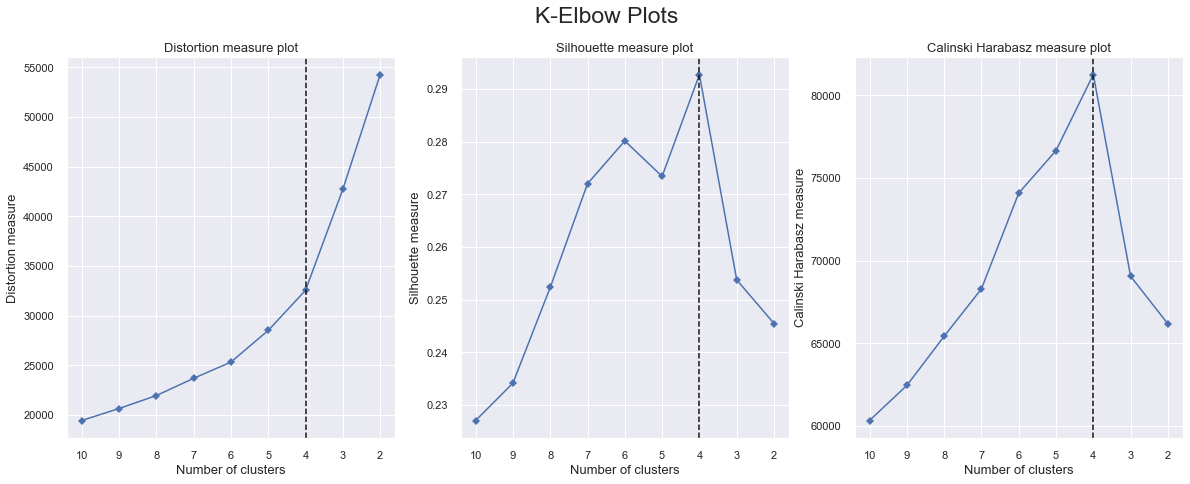

In [423]:
# Instantiate a scikit-learn K-Means model for cust_prof variables
clus_estim = KMeans(random_state=1)
# K-elbow plots
kelbowplots(clus_estim, dfs)

In [424]:
X_3m, dfs_3m = kmeans_clustering(dfs, 4)

In [425]:
columns_cluster = ['order_dow', 'order_hour_of_day', 
                   'days_since_prior_order', 'number_of_items',
                  '%_of_reordered']

In [426]:
rsq(dfs_3m, columns_cluster)

'rsq is:'

0.5493162403805741

In [433]:
dfs_3m.groupby('cluster').mean()

order_dow  order_hour_of_day  days_since_prior_order  \
cluster                                                         
0         0.771306           0.583365                0.235551   
1         0.472505           0.593767                0.156020   
2         0.450363           0.592009                0.907301   
3         0.143724           0.576824                0.254504   

         number_of_items  %_of_reordered  
cluster                                   
0               0.066415        0.794767  
1               0.061068        0.144985  
2               0.069418        0.489051  
3               0.069979        0.785263

In [ ]:
#Cluster 0: End of the Week buyers, mostly early afternoon purchases, high recency (~4 days), low number of items, repurchase a lot.
#Cluster 3: Beginning of the Week buyers, mostly early afternoon purchases, high recency (~4 days), low number of items, repurchase a lot.


In [438]:
melted = pd.melt(dfs_3m.groupby('cluster').mean().reset_index(),\
                 id_vars = ['cluster'], value_vars = dfs_3m.columns.values[:-1])
fig_melted = px.line(melted, x = "variable", y = "value", color = 'cluster',\
                       title='Cluster Time Analysis',\
                   height=600, width=1200).update_traces(mode='lines+markers')
fig_melted.show()

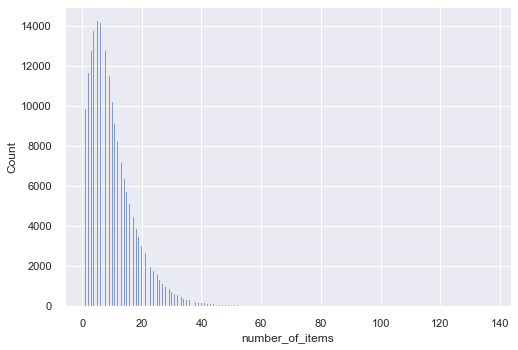

In [451]:
sns.histplot(df_g.number_of_items)

#### We realize that clusters converged to very close numbers and that could caused by outliers driving the solution. Threfore, we proceed to cap the maximum value of number of items at the third quartile value + 2 standard deviations, which accounts to 54

In [464]:
#df_g[df_g.number_of_items > 54]['number_of_items'] = 54
df_g.loc[df_g[df_g.number_of_items > 54].index, 'number_of_items'] = 54

In [465]:
df_g.number_of_items.describe()

count    199981.000000
mean         10.090464
std           7.497184
min           1.000000
25%           5.000000
50%           8.000000
75%          14.000000
max          54.000000
Name: number_of_items, dtype: float64

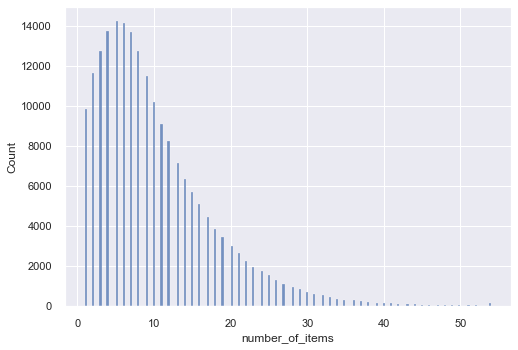

In [466]:
sns.histplot(df_g.number_of_items)

In [467]:
dfs_2 = pd.DataFrame(prep.MinMaxScaler().fit_transform(df_g), columns=df_g.columns.values)

In [471]:
dfs_2.drop('cluster', axis=1, inplace=True)

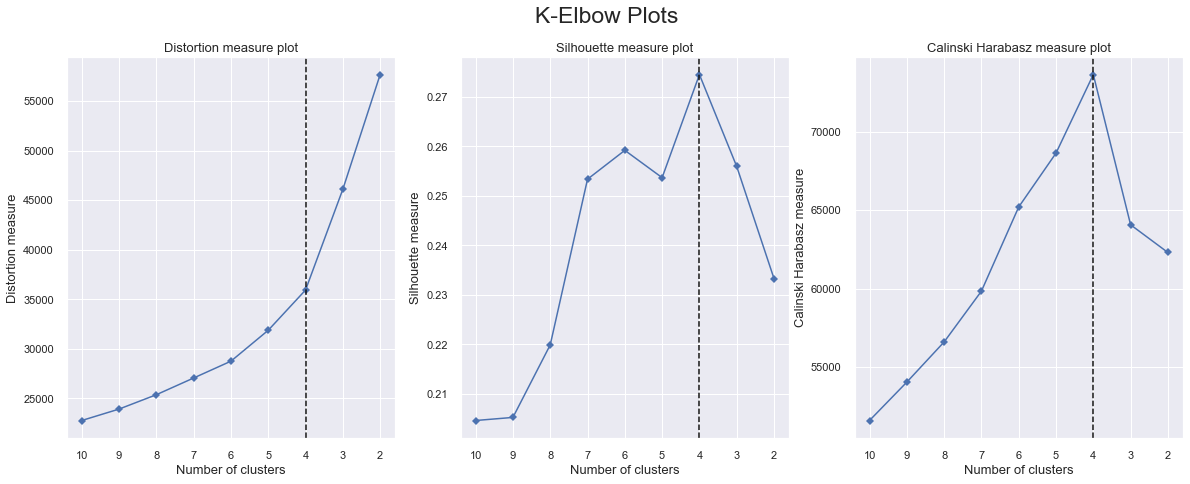

In [472]:
# Instantiate a scikit-learn K-Means model for cust_prof variables
clus_estim = KMeans(random_state=1)
# K-elbow plots
kelbowplots(clus_estim, dfs_2)

In [430]:
df_g['cluster'] = dfs_3m['cluster']

In [477]:
X_4m_2, dfs_4m_2 = kmeans_clustering(dfs_2, 4)
rsq(dfs_4m_2, columns_cluster)

'rsq is:'

0.5248924418263767

In [479]:
melted = pd.melt(dfs_4m_2.groupby('cluster').mean().reset_index(),\
                 id_vars = ['cluster'], value_vars = dfs_4m_2.columns.values[:-1])
fig_melted = px.line(melted, x = "variable", y = "value", color = 'cluster',\
                       title='Cluster Time Analysis',\
                   height=600, width=1200).update_traces(mode='lines+markers')
fig_melted.show()

In [254]:
df_c.rename({'order_hour_of_day_x': 'order_hour_of_day', 'days_since_prior_order_x': 'days_since_prior_order'},\
            axis=1, inplace=True)
df_c.head()

order_id  add_to_cart_order  reordered      product_name department  \
0        10                  1          1      fresh fruits    produce   
1        10                  2          1  fresh vegetables    produce   
2        10                  3          0       fresh herbs    produce   
3        10                  4          1      fresh fruits    produce   
4        10                  5          1  fresh vegetables    produce   

   user_id  order_number  order_dow  order_hour_of_day  \
0   135442             4          6                  8   
1   135442             4          6                  8   
2   135442             4          6                  8   
3   135442             4          6                  8   
4   135442             4          6                  8   

   days_since_prior_order  cluster  
0                     8.0      1.0  
1                     8.0      1.0  
2                     8.0      1.0  
3                     8.0      1.0  
4                     8.0      1.0

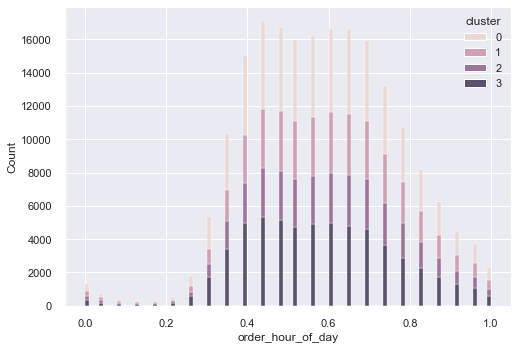

In [481]:
sns.histplot(x=dfs_4m_2.order_hour_of_day, hue=dfs_4m_2.cluster, multiple='stack')

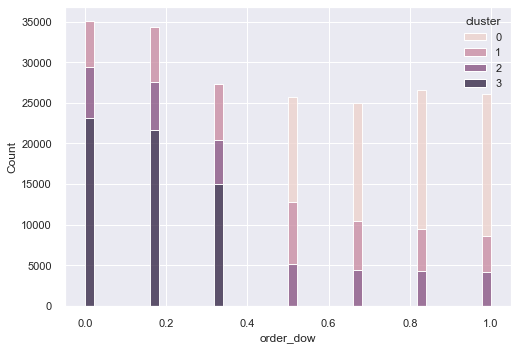

In [480]:
sns.histplot(x=dfs_4m_2.order_dow, hue=dfs_4m_2.cluster, multiple='stack')

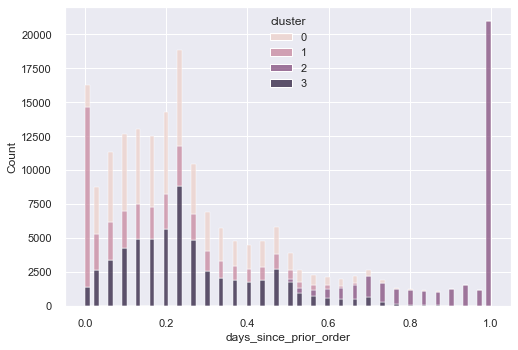

In [445]:
sns.histplot(x=dfs_3m.days_since_prior_order, hue=dfs_3m.cluster, multiple='stack')

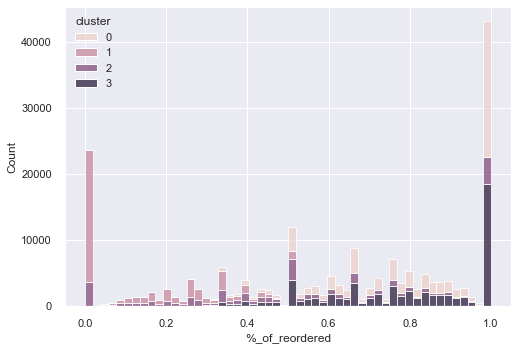

In [448]:
sns.histplot(x=dfs_3m['%_of_reordered'], hue=dfs_3m.cluster, multiple='stack')

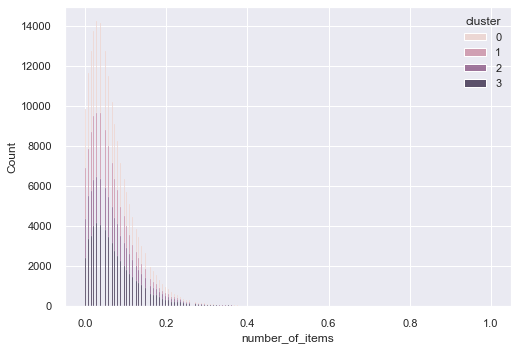

In [449]:
sns.histplot(x=dfs_3m['number_of_items'], hue=dfs_3m.cluster, multiple='stack')

### Analyze the clusters on these 5 features! 

In [497]:
dfs_4m_2['order_id'] = df_g.reset_index()['order_id']

In [508]:
pt_merge=pt_prods.reset_index().order_id

In [512]:
pt_ri =pt_prods.reset_index()

In [510]:
df_ord_clus = pd.merge(dfs_4m_2, pt_merge, how='left', on='order_id')

In [513]:
df_ord_clus = pd.merge(df_ord_clus, pt_ri, how='left', on='order_id')
df_ord_clus.head()

order_dow  order_hour_of_day  days_since_prior_order  number_of_items  \
0   1.000000           0.347826                0.266667         0.264151   
1   0.166667           0.826087                0.766667         0.075472   
2   0.500000           0.565217                0.200000         0.283019   
3   1.000000           0.695652                0.800000         0.150943   
4   0.000000           0.521739                0.066667         0.169811   

   %_of_reordered  cluster  order_id  air fresheners candles  asian foods  \
0        0.533333        0        10                     0.0          0.0   
1        1.000000        3        11                     0.0          0.0   
2        0.875000        0        28                     0.0          0.0   
3        0.111111        2        38                     0.0          0.0   
4        0.700000        3        56                     0.0          0.0   

   baby accessories  ...  spreads  tea  tofu meat alternatives  \
0               0.0  ...      0.0  0.0                     0.0   
1               0.0  ...      0.0  0.0                     0.0   
2               0.0  ...      1.0  0.0                     0.0   
3               0.0  ...      0.0  0.0                     0.0   
4               0.0  ...      0.0  0.0                     0.0   

   tortillas flat bread  trail mix snack mix  trash bags liners  \
0                   0.0                  0.0                0.0   
1                   0.0                  0.0                0.0   
2                   0.0                  0.0                0.0   
3                   0.0                  0.0                0.0   
4                   0.0                  0.0                0.0   

   vitamins supplements  water seltzer sparkling water  white wines  yogurt  
0                   0.0                            0.0          0.0     0.0  
1                   0.0                            0.0          0.0     0.0  
2                   0.0                            0.0          0.0     1.0  
3                   0.0                            0.0          0.0     0.0  
4                   0.0                            0.0          0.0     0.0  

[5 rows x 141 columns]

In [556]:
df_ord_clus.groupby('cluster').mean().iloc[:,6:].T.sort_values(by=0, ascending=False).iloc[:50,:]

cluster                               0         1         2         3
fresh fruits                   0.583825  0.463910  0.515170  0.617164
fresh vegetables               0.434565  0.417084  0.447619  0.472136
packaged vegetables fruits     0.367824  0.316400  0.359542  0.401412
yogurt                         0.277891  0.205743  0.254529  0.295679
milk                           0.266061  0.182507  0.219702  0.277170
packaged cheese                0.229088  0.211600  0.242864  0.239766
water seltzer sparkling water  0.205315  0.152497  0.200522  0.204622
soy lactosefree                0.177916  0.132858  0.169031  0.183335
chips pretzels                 0.171051  0.153955  0.179098  0.173060
bread                          0.169310  0.136221  0.165891  0.176725
refrigerated                   0.142056  0.114396  0.130868  0.141631
eggs                           0.138365  0.108069  0.150552  0.146417
frozen produce                 0.119041  0.113737  0.132634  0.126586
crackers                       0.113706  0.104259  0.120801  0.120461
ice cream ice                  0.112546  0.114302  0.118810  0.100780
lunch meat                     0.102327  0.090054  0.107005  0.113532
cream                          0.099249  0.076037  0.084207  0.099190
fresh dips tapenades           0.096719  0.084527  0.108407  0.103424
cereal                         0.091900  0.082034  0.101621  0.095358
juice nectars                  0.091642  0.084198  0.092928  0.088680
soft drinks                    0.089546  0.085138  0.098817  0.079693
fresh herbs                    0.088257  0.100473  0.095956  0.090889
energy granola bars            0.087274  0.067382  0.082385  0.101935
other creams cheeses           0.084453  0.085397  0.092648  0.085718
hot dogs bacon sausage         0.083277  0.078224  0.095424  0.082706
nuts seeds dried fruit         0.081391  0.075025  0.078908  0.083526
spreads                        0.075186  0.073849  0.083226  0.081400
candy chocolate                0.074203  0.063572  0.060485  0.073585
butter                         0.073204  0.071004  0.082160  0.073217
soup broth bouillon            0.072785  0.091371  0.098705  0.079526
frozen meals                   0.072108  0.068040  0.086787  0.073702
baking ingredients             0.070657  0.094475  0.081039  0.067544
breakfast bakery               0.068917  0.057951  0.067859  0.073518
packaged produce               0.065548  0.048637  0.068785  0.064699
dry pasta                      0.064952  0.068910  0.078122  0.071376
canned jarred vegetables       0.064098  0.076107  0.080955  0.071594
canned meals beans             0.063695  0.064113  0.080310  0.073619
oils vinegars                  0.062969  0.076883  0.075066  0.060532
frozen breakfast               0.062196  0.051083  0.065027  0.064983
cookies cakes                  0.061180  0.056539  0.059391  0.060699
paper goods                    0.059311  0.063054  0.078599  0.059427
tea                            0.059134  0.054964  0.057035  0.056264
coffee                         0.057538  0.047249  0.055774  0.059611
pasta sauce                    0.056265  0.061690  0.072907  0.063895
tortillas flat bread           0.052542  0.051883  0.062532  0.060163
condiments                     0.052413  0.071215  0.066597  0.054189
frozen appetizers sides        0.051736  0.047320  0.056559  0.052482
baby food formula              0.050575  0.034902  0.036285  0.052800
fruit vegetable snacks         0.047352  0.038359  0.043043  0.052097
instant foods                  0.046675  0.049437  0.062728  0.052950

In [546]:
ndf = df_ord_clus.groupby('cluster').mean().iloc[:,6:].T

In [547]:
ndf['mean']=df_ord_clus.groupby('cluster').mean().iloc[:,6:].T.mean(axis=1)

### Try to divide the value for each column by the mean...

In [558]:
ndf[['0','1','2','3']].div(ndf.mean, axis=0)

KeyError: "None of [Index(['0', '1', '2', '3'], dtype='object', name='cluster')] are in the [columns]"

In [557]:
ndf.iloc[:,:-1].div(ndf.mean, axis=0)

TypeError: <class 'method'>